# 10x RNA-seq gene expression data (part 1)

To efficiently handle data transfer and download, the 4 million cell 10X dataset, was subdivide into 24 expression matrices where cells are grouped by 10X chemistry (10Xv2, 10Xv3 and 10XMulti) and the broad anatomical region from where the cells were dissected from.

The purpose of this set of notebooks is to provide an overview of the data, the file organization and how to combine data and metadata through example use cases.

You need to be connected to the internet to run this notebook and have run through the [getting started notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html).

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(download_base)

abc_cache.current_manifest

'releases/20241115/manifest.json'

## Data overview
### Cell metadata

Essential cell metadata is stored as a dataframe. Each row represents one cell indexed by a *cell label*. The *cell label* is the concatenation of barcode and name of the sample. In this context, the sample is the *barcoded cell sample* that represents a single load into one port of the 10x Chromium. Note that cell barcodes are only unique within a single *barcoded cell sample* and that the same barcode can be reused. The *barcoded cell sample* label or name is unique in the database.

Each cell is associated with a *library label*, *library method*, *donor label*, *donor genotype*, *donor sex*, dissection *region of interest acronym", the corresponding coarse *anatomical division label* and the *matrix_prefix* identifying which data package this cell is part of.

Further, each cell is associated with a *cluster alias* representing which cluster this cell is a member of and (x,y) coordinates of the all cells UMAP in Figure 1 of the manuscript.

Below, we list the metadata files we will be using in this tutorial.

In [3]:
abc_cache.list_metadata_files('WMB-10X')

['cell_metadata',
 'cell_metadata_with_cluster_annotation',
 'example_genes_all_cells_expression',
 'gene',
 'region_of_interest_metadata']

In [4]:
abc_cache.list_metadata_files('WMB-taxonomy')

['cluster',
 'cluster_annotation_term',
 'cluster_annotation_term_set',
 'cluster_annotation_term_with_counts',
 'cluster_to_cluster_annotation_membership',
 'cluster_to_cluster_annotation_membership_color',
 'cluster_to_cluster_annotation_membership_pivoted']

In [5]:
abc_cache.get_directory_metadata('WMB-taxonomy')

[PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/cluster.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/cluster_annotation_term.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/cluster_annotation_term_set.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/views/cluster_annotation_term_with_counts.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/cluster_to_cluster_annotation_membership.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/views/cluster_to_cluster_annotation_membership_color.csv'),
 PosixPath('/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/metadata/WMB-taxonomy/20231215/views/cluster_to_cluster_annotation_membership_pivoted.

In [6]:
abc_cache.list_data_files('WMB-10Xv3')

['WMB-10Xv3-CB/log2',
 'WMB-10Xv3-CB/raw',
 'WMB-10Xv3-CTXsp/log2',
 'WMB-10Xv3-CTXsp/raw',
 'WMB-10Xv3-HPF/log2',
 'WMB-10Xv3-HPF/raw',
 'WMB-10Xv3-HY/log2',
 'WMB-10Xv3-HY/raw',
 'WMB-10Xv3-Isocortex-1/log2',
 'WMB-10Xv3-Isocortex-1/raw',
 'WMB-10Xv3-Isocortex-2/log2',
 'WMB-10Xv3-Isocortex-2/raw',
 'WMB-10Xv3-MB/log2',
 'WMB-10Xv3-MB/raw',
 'WMB-10Xv3-MY/log2',
 'WMB-10Xv3-MY/raw',
 'WMB-10Xv3-OLF/log2',
 'WMB-10Xv3-OLF/raw',
 'WMB-10Xv3-P/log2',
 'WMB-10Xv3-P/raw',
 'WMB-10Xv3-PAL/log2',
 'WMB-10Xv3-PAL/raw',
 'WMB-10Xv3-STR/log2',
 'WMB-10Xv3-STR/raw',
 'WMB-10Xv3-TH/log2',
 'WMB-10Xv3-TH/raw']

Below, we load the first of the metadata used in this tutorial. This pattern of loading metadata is repeated throughout the tutorials.

In [7]:
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print("Number of cells = ", len(cell))
cell.head(5)

cell_metadata.csv: 100%|█████████████████████████████████████████████████████████████████████| 1.01G/1.01G [00:38<00:00, 26.0MMB/s]


Number of cells =  4042976


,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,donor_sex,dataset_label,x,y,cluster_alias,abc_sample_id
cell_label,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.146826,-3.086639,1,484be5df-5d44-4bfe-9652-7b5bc739c211
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.138481,-3.022000,1,5638505d-e1e8-457f-9e5b-59e3e2302417
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.472557,-2.992709,1,a0544e29-194f-4d34-9af4-13e7377b648f
CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.379622,-3.043442,1,c777ac0b-77e1-4d76-bf8e-2b3d9e08b253
AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,F,WMB-10Xv3,23.909480,-2.601536,1,49860925-e82b-46df-a228-fd2f97e75d39


We can use panadas groupby function to see how many unique items are associated for each field and list them out if the number of items is small.

In [8]:
def print_column_info(df):
    
    for c in df.columns:
        grouped = df[[c]].groupby(c).count()
        members = ''
        if len(grouped) < 30:
            members = str(list(grouped.index))
        print("Number of unique %s = %d %s" % (c, len(grouped), members))
        

In [9]:
print_column_info(cell)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

In [10]:
cell.groupby('dataset_label')[['x']].count()

,x
dataset_label,
WMB-10XMulti,1687
WMB-10Xv2,1699939
WMB-10Xv3,2341350


We can also bring in the pivot table from the "cluster annotation tutorial" to associate each cell with terms at each cell type classification level.

In [11]:
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)
cluster_details.head(5)

,neurotransmitter,class,subclass,supertype,cluster
cluster_alias,,,,,
1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3
2,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
3,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0322 L2 IT PPP-APr Glut_2
4,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
5,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0325 L2 IT PPP-APr Glut_2


In [12]:
cluster_colors = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_color'
)
cluster_colors.set_index('cluster_alias', inplace=True)
cluster_colors.head(5)

,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cluster_alias,,,,,
1,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F
2,#2B93DF,#FA0087,#0F6632,#266DFF,#CCA73D
3,#2B93DF,#FA0087,#0F6632,#002BCC,#99000D
4,#2B93DF,#FA0087,#0F6632,#002BCC,#5C8899
5,#2B93DF,#FA0087,#0F6632,#002BCC,#473D66


In [13]:
roi = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='region_of_interest_metadata')
roi.set_index('acronym', inplace=True)
roi.rename(columns={'order': 'region_of_interest_order',
                    'color_hex_triplet': 'region_of_interest_color'},
           inplace=True)
roi.head(5)

region_of_interest_metadata.csv: 100%|███████████████████████████████████████████████████████| 1.40k/1.40k [00:00<00:00, 23.7kMB/s]


,label,name,region_of_interest_order,region_of_interest_color
acronym,,,,
MO-FRP,WMB-MO-FRP,Somatomotor - Frontal pole,0,#3DCC7C
MOp,WMB-MOp,Primary motor area,1,#179968
SS-GU-VISC,WMB-SS-GU-VISC,Somatosensory/gustatory/visceral areas,2,#2E8599
SSp,WMB-SSp,Primary somatosensory area,3,#5CCCCC
AUD,WMB-AUD,Auditory areas,4,#455A99


In [14]:
cell_extended = cell.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias')
cell_extended = cell_extended.join(roi[['region_of_interest_order', 'region_of_interest_color']], on='region_of_interest_acronym')
cell_extended.head(5)

,cell_barcode,barcoded_cell_sample_label,library_label,feature_matrix_label,entity,brain_section_label,library_method,region_of_interest_acronym,donor_label,donor_genotype,...,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,region_of_interest_order,region_of_interest_color
cell_label,,,,,,,,,,,,,,,,,,,,,
GCGAGAAGTTAAGGGC-410_B05,GCGAGAAGTTAAGGGC,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AATGGCTCAGCTCCTT-411_B06,AATGGCTCAGCTCCTT,411_B06,L8TX_201029_01_E10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550851,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AACACACGTTGCTTGA-410_B05,AACACACGTTGCTTGA,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
CACAGATAGAGGCGGA-410_A05,CACAGATAGAGGCGGA,410_A05,L8TX_201029_01_A10,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C
AAAGTGAAGCATTTCG-410_B05,AAAGTGAAGCATTTCG,410_B05,L8TX_201030_01_C12,WMB-10Xv3-HPF,cell,NaN,10Xv3,RHP,Snap25-IRES2-Cre;Ai14-550850,Ai14(RCL-tdT)/wt,...,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3,#2B93DF,#FA0087,#0F6632,#266DFF,#64661F,15,#CCB05C


In [15]:
print_column_info(cell_extended)

Number of unique cell_barcode = 2375490 
Number of unique barcoded_cell_sample_label = 819 
Number of unique library_label = 819 
Number of unique feature_matrix_label = 24 ['WMB-10XMulti', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-HPF', 'WMB-10Xv2-HY', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4', 'WMB-10Xv2-MB', 'WMB-10Xv2-OLF', 'WMB-10Xv2-TH', 'WMB-10Xv3-CB', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HPF', 'WMB-10Xv3-HY', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-Isocortex-2', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-P', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-TH']
Number of unique entity = 1 ['cell']
Number of unique brain_section_label = 0 []
Number of unique library_method = 3 ['10Xv2', '10Xv3', '10xRSeq_Mult']
Number of unique region_of_interest_acronym = 29 ['ACA', 'AI', 'AUD', 'AUD-TEa-PERI-ECT', 'CB', 'CTXsp', 'ENT', 'HIP', 'HY', 'LSX', 'MB', 'MO-FRP', 'MOp', 'MY', 'OLF', 'P', 'PAL', 'PL-ILA-ORB', 'RHP', 'RSP', 'SS-GU-VISC', 'SS

The joined table above can be written to disk be later use, however, a copy can be found in the cache as under the name 'cell_metadata_with_cluster_annotation'.

### UMAP spatial embedding

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualizing and exploring large-dimension datasets. The x, y columns of the cell metadata table represents the coordinate of the all cells UMAP in Figure 1 of the manuscript. 

We define a small helper function *plot umap* to visualize the cells on the UMAP colorized by: dissection region of interest, neurotransmitter identity, cell types division, class and subclass. For ease of demostration, we do a simple subsampling of the cells by a factor of 10 to reduce processing time.

In [16]:
def plot_umap(xx, yy, cc=None, val=None, fig_width=8, fig_height=8, cmap=None):

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    
    if cmap is not None :
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.')
        
    ax.axis('equal')
    ax.set_xlim(-18, 27)
    ax.set_ylim(-18, 27)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

In [17]:
cell_subsampled = cell_extended.loc[::10]
print(len(cell_subsampled))

404298


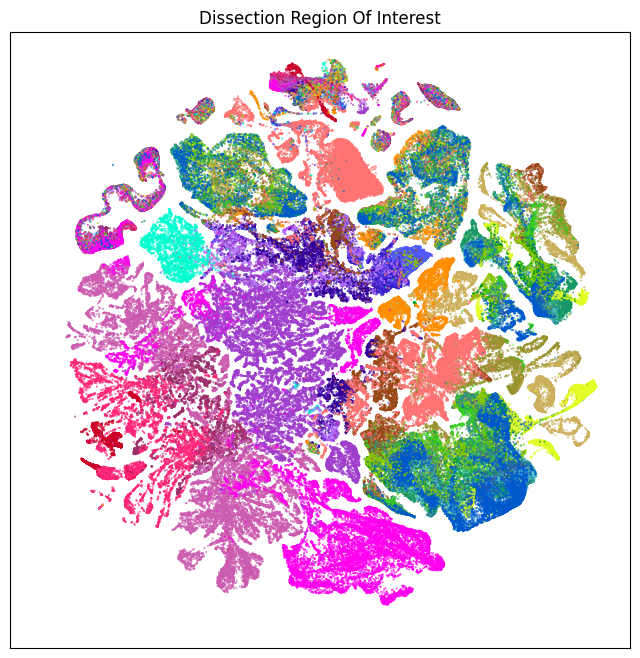

In [18]:
fig, ax = plot_umap(cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['region_of_interest_color'])
res = ax.set_title("Dissection Region Of Interest")
plt.show()

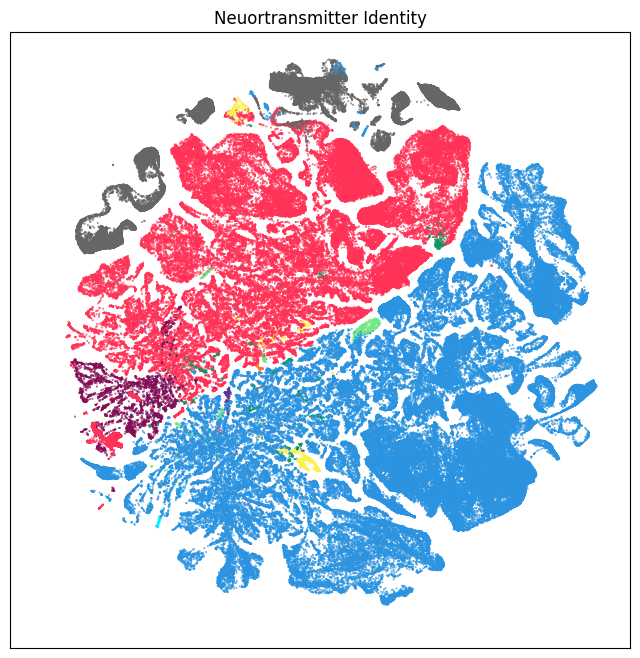

In [19]:
fig, ax = plot_umap(cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter Identity")
plt.show()

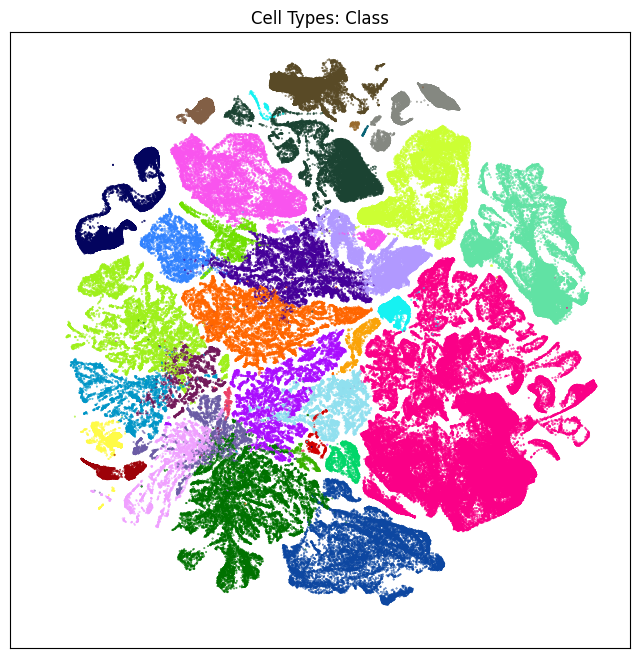

In [20]:
fig, ax = plot_umap(cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['class_color'])
res = ax.set_title("Cell Types: Class")
plt.show()

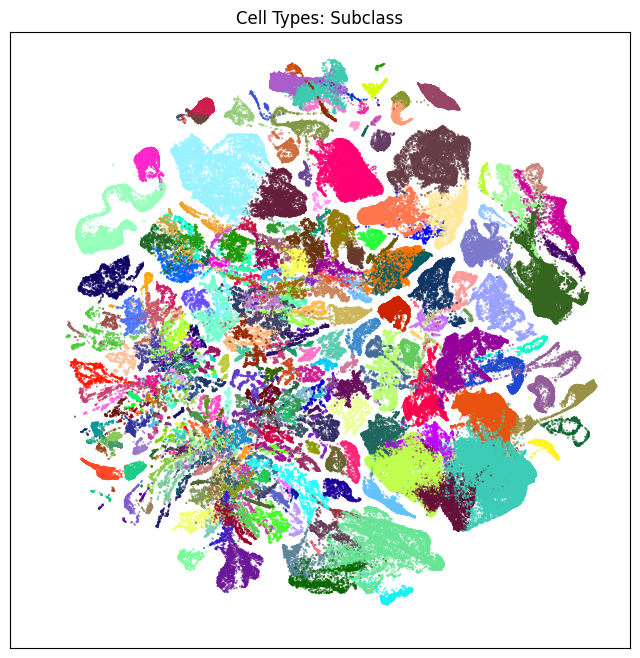

In [21]:
fig, ax = plot_umap(cell_subsampled['x'], cell_subsampled['y'], cc=cell_subsampled['subclass_color'])
res = ax.set_title("Cell Types: Subclass")
plt.show()

### Single cell transcriptomes

Each 10x library was sequenced on the Illumina NovaSeq6000 platform, and sequencing reads were aligned to the mouse 
reference transcriptome mm10 (GENCODE vM23/Ensembl 98) using the 10x Genomics CellRanger pipeline (version 6.1.1) with default parameters. Each gene is uniquely identifier by an Ensembl ID. It is best practice to gene identifier to for tracking and data interchange as gene symbols are not unique and can change over time

Each row of the gene dataframe has Ensembl gene identifier, a gene symbol and name. 1173 genes have no expression across all the cells in the dataset and can be identified by "no expression" in the comment column.

In [22]:
gene = abc_cache.get_metadata_dataframe(directory='WMB-10X', file_name='gene')
gene.set_index('gene_identifier', inplace=True)
print("Number of genes = ", len(gene))
gene.head(5)

Number of genes =  32285


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000051951,Xkr4,X-linked Kx blood group related 4,NCBIGene:497097,NaN
ENSMUSG00000089699,Gm1992,predicted gene 1992,NaN,NaN
ENSMUSG00000102331,Gm19938,"predicted gene, 19938",NaN,NaN
ENSMUSG00000102343,Gm37381,"predicted gene, 37381",NaN,NaN
ENSMUSG00000025900,Rp1,retinitis pigmentosa 1 (human),NCBIGene:19888,NaN


In [23]:
pred = (gene['comment'] == 'no expression')
filtered = gene[pred]
print("Number of no expression genes", len(filtered))
filtered

Number of no expression genes 1173


,gene_symbol,name,mapped_ncbi_identifier,comment
gene_identifier,,,,
ENSMUSG00000118272,Arhgef4,Rho guanine nucleotide exchange factor (GEF) 4,NaN,no expression
ENSMUSG00000117809,Asdurf,Asnsd1 upstream reading frame,NCBIGene:110599589,no expression
ENSMUSG00000047383,AC169382.1,novel transcript,NaN,no expression
ENSMUSG00000097001,1700054K02Rik,RIKEN cDNA 1700054K02 gene,NaN,no expression
ENSMUSG00000116048,Sept2,septin 2,NaN,no expression
...,...,...,...,...
ENSMUSG00000091585,AC140365.1,PRAME family member 8-like,NaN,no expression
ENSMUSG00000095523,AC124606.1,PRAME family member 8-like,NCBIGene:100038995,no expression
ENSMUSG00000095475,AC133095.2,uncharacterized LOC545763,NCBIGene:545763,no expression


### Gene expression matrices

The 4 million cell dataset has been divided into 24 expression matrices to make data transfer and download more efficient. Each package is formatted as an annadata h5ad file with minimal metadata. In this next section, we provide example code on how to open one of the expression matrix files and connect with the rich cell level metadata discussed above.

For each subset, there are two h5ad files one storing the raw counts and the other log normalization of it. For this example, we will use the log2 version of the expression matrix.

Below we list the available files in the WMB-10Xv2 directoy and load the WMB-10Xv2-TH data.

In [24]:
abc_cache.list_data_files('WMB-10Xv2')

['WMB-10Xv2-CTXsp/log2',
 'WMB-10Xv2-CTXsp/raw',
 'WMB-10Xv2-HPF/log2',
 'WMB-10Xv2-HPF/raw',
 'WMB-10Xv2-HY/log2',
 'WMB-10Xv2-HY/raw',
 'WMB-10Xv2-Isocortex-1/log2',
 'WMB-10Xv2-Isocortex-1/raw',
 'WMB-10Xv2-Isocortex-2/log2',
 'WMB-10Xv2-Isocortex-2/raw',
 'WMB-10Xv2-Isocortex-3/log2',
 'WMB-10Xv2-Isocortex-3/raw',
 'WMB-10Xv2-Isocortex-4/log2',
 'WMB-10Xv2-Isocortex-4/raw',
 'WMB-10Xv2-MB/log2',
 'WMB-10Xv2-MB/raw',
 'WMB-10Xv2-OLF/log2',
 'WMB-10Xv2-OLF/raw',
 'WMB-10Xv2-TH/log2',
 'WMB-10Xv2-TH/raw']

In [25]:
feature_matrix_label = 'WMB-10Xv2-TH'
file = abc_cache.get_data_path(directory='WMB-10Xv2', file_name='WMB-10Xv2-TH/log2')
print(file)

WMB-10Xv2-TH-log2.h5ad: 100%|████████████████████████████████████████████████████████████████| 4.04G/4.04G [02:35<00:00, 25.9MMB/s]

/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad


We use the anndata's *read_h5ad* function to open the package for the log2 normalization file. The "backed='r'" makes use of the lazy loading functionality to only load required data. By default, anndata will load the entire expression matrix in memory.

In [26]:
adata = anndata.read_h5ad(file, backed='r')
print(adata)

AnnData object with n_obs × n_vars = 131212 × 32285 backed at '/allen/scratch/aibstemp/chris.morrison/src/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-TH-log2.h5ad'
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


Genes are represented as "variables". For this data, the *var* dataframe is indexed by the Ensembl gene identifier with one metadata column *gene symbol*.

In [27]:
print("Number of genes = ", len(adata.var))
adata.var.index[0:5]

Number of genes =  32285


Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102331',
       'ENSMUSG00000102343', 'ENSMUSG00000025900'],
      dtype='object', name='gene_identifier')

Cells are represented as "observations". For this data, the *obs* dataframe is index by *cell label* with three minimal metadata columns *cell barcode*, *library label* and *anatomical division label*. 

In [28]:
print("Number of cells = ", len(adata.obs))
adata.obs.index[0:5]

Number of cells =  131212


Index(['CAGGTGCAGGCTAGCA-040_C01', 'TGCGCAGGTTGCGCAC-045_C01',
       'CGATGTATCTTGCCGT-042_B01', 'GACTAACGTCCTCTTG-040_B01',
       'GATCGTACAACTGCTA-040_B01'],
      dtype='object', name='cell_label')

We can easily connect the cells in the package to the extended cell metadata with simple pandas filtering.

In [29]:
pred = (cell_extended['feature_matrix_label'] == feature_matrix_label)
cell_filtered = cell_extended[pred]
print("Number of cells = ", len(cell_filtered))

Number of cells =  130555


## Example use cases

In this section, we explore two use cases. The first example looks at the expression of nine canonical neurotransmitter transporter genes and the second the expression of gene Tac2.

To support these use cases, we will create a smaller submatrix (all cells and 10 genes) that read it into memory. *Note this operation takes around 10 seconds*.

In [30]:
ntgenes = ['Slc17a7', 'Slc17a6', 'Slc17a8', 'Slc32a1', 'Slc6a5', 'Slc18a3', 'Slc6a3', 'Slc6a4', 'Slc6a2']
exgenes = ['Tac2']
gnames = ntgenes + exgenes
pred = [x in gnames for x in adata.var.gene_symbol]
gene_filtered = adata.var[pred]
gene_filtered

,gene_symbol
gene_identifier,
ENSMUSG00000037771,Slc32a1
ENSMUSG00000070570,Slc17a7
ENSMUSG00000039728,Slc6a5
ENSMUSG00000030500,Slc17a6
ENSMUSG00000055368,Slc6a2
ENSMUSG00000019935,Slc17a8
ENSMUSG00000025400,Tac2
ENSMUSG00000020838,Slc6a4
ENSMUSG00000021609,Slc6a3


In [31]:
start = time.process_time()
asubset = adata[:, gene_filtered.index].to_memory()
print("time taken: ", time.process_time() - start)
print(asubset)

time taken:  3.9703891139999996
AnnData object with n_obs × n_vars = 131212 × 10
    obs: 'cell_barcode', 'library_label', 'anatomical_division_label'
    var: 'gene_symbol'
    uns: 'normalization', 'parent', 'parent_layer', 'parent_rows'


We define two helper functions to (1) *create_expression_dataframe*: create joined gene expression and cell metadata dataframe based for a set of input genes and (2) *aggregate_by_metadata* which computes the average expression for each term in a given category.

In [32]:
def create_expression_dataframe(ad, gf) :
    gdata = ad[:, gf.index].to_df()
    gdata.columns = gf.gene_symbol
    joined = cell_filtered.join(gdata)
    return joined

In [33]:
def aggregate_by_metadata(df, gnames, value, sort=False):
    grouped = df.groupby(value)[gnames].mean()
    if sort:
        grouped = grouped.sort_values(by=gnames[0], ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes in the thalamus

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of cells in the 'WMB-10Xv2-TH' package and expression of the 9 solute carrier family genes. We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group. We define a helper function that display a dataframe as a heatmap for visualization.

In [34]:
def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmax=None):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels(ylabs)

Within the thalamus, Slc17a7 is most enriched in cholinergic assigned cells with some expression in glutamatergic types. Genes Slc17a6 is enriched in glutamatergic, Slc32a1 in GABAergic, Slc6a5 in glycinergic, Slc18a3 in cholinergic and Slc6a3 in dopaminergic types, matching the expectation described in the manuscript.

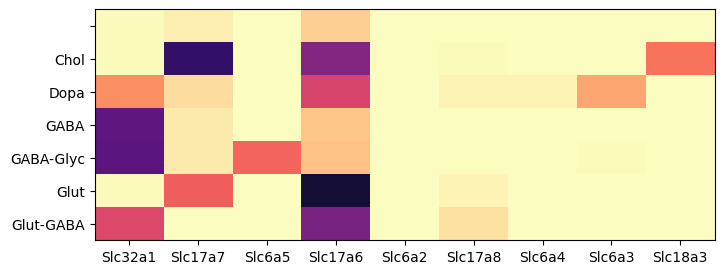

In [35]:
pred = [x in ntgenes for x in asubset.var.gene_symbol]
gf = asubset.var[pred]

ntexp = create_expression_dataframe(asubset, gf)
agg = aggregate_by_metadata(ntexp, gf.gene_symbol, 'neurotransmitter')
plot_heatmap(df=agg, fig_width=8, fig_height=3, vmax=10)
plt.show()

### Expression of Tachykinin 2 (Tac2) in the thalamus

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising of cells in the 'WMB-10Xv2-TH' package and expression values of Tac2 in those cells.

In [36]:
gf = asubset.var[asubset.var.gene_symbol == 'Tac2']
tac2 = create_expression_dataframe(asubset, gf)

Grouping cells by neurotransmitter identites and computing the mean expression in each group, we can observed that Tac2 gene is highly enriched in cholinergic cell types.

/tmp/ipykernel_5015/199257058.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


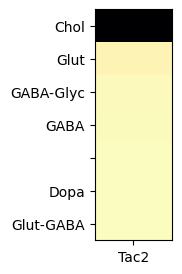

In [37]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'neurotransmitter', True).head(10)
plot_heatmap(agg, 1, 3)
plt.show()

Grouping cells by cell types class, shows that Tac2 is enriched in class "16 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic types.

/tmp/ipykernel_5015/199257058.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


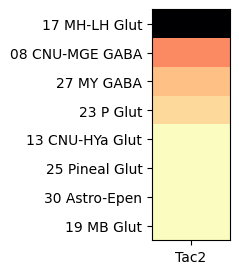

In [38]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'class', True).head(8)
plot_heatmap(agg, 1, 3)
plt.show()

At the next level, grouping by subclass, shows Tac2 is enriched in sublcass "145 MH Tac2 Glut" with further specificity to the medial habenula and with Tac2 itself as a marker for the subclass.

/tmp/ipykernel_5015/199257058.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


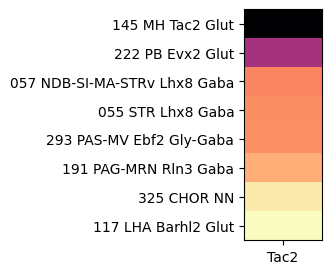

In [39]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'subclass', True).head(8)
plot_heatmap(agg, 1, 3)
plt.show()

Next level down, gene Tac2 is enriched in several children supertypes of "145 MH Tac2 Glut"

/tmp/ipykernel_5015/199257058.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  grouped = grouped.sort_values(by=gnames[0], ascending=False)


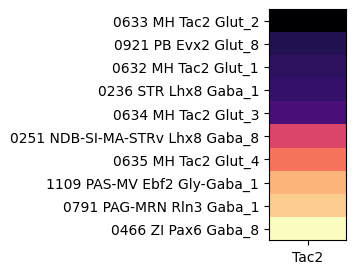

In [40]:
agg = aggregate_by_metadata(tac2, gf.gene_symbol, 'supertype', True).head(10)
plot_heatmap(agg, 1, 3)
plt.show()

Close h5ad file and clean up

In [41]:
adata.file.close()
del adata